<a href="https://colab.research.google.com/github/jmestanza/natural-language-processing-practice/blob/main/desafios/Desafio_2/Desafio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Crear sus propios vectores con Gensim
basado en lo visto en clase con otro
dataset.
Probar términos de interés y explicar
similitudes en el espacio de embeddings.
Intentar plantear y probar tests de
analogías. Graficar los embeddings
resultantes.
Sacar conclusiones.

Algunos de los sitios de textos sugeridos fueron:
- [Project Gutenberg](https://www.gutenberg.org/browse/scores/top)
- [Textos.info](https://www.textos.info/)

Se eligió analizar los textos pertenecientes a [The Project Gutenberg eBook of The Adventures of Sherlock Holmes](https://www.gutenberg.org/cache/epub/1661/pg1661.txt)


Por razones de compatibilidad con gensim, pandas y numpy hay que correr la siguiente linea de código.

In [1]:
!pip uninstall -y numpy gensim pandas
!pip install --upgrade numpy gensim pandas==2.2.2

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylin

In [2]:
import pandas as pd

In [3]:
import os
filename = 'dataset.txt'
text_path = 'https://raw.githubusercontent.com/jmestanza/natural-language-processing-practice/refs/heads/main/desafios/Desafio_2/the_adventures_of_sherlock_holmes.txt'
curr_dir = os.getcwd()
dataset_path = os.path.join(curr_dir, filename)
if not os.path.exists(dataset_path):
  !wget {text_path} -O {filename}

os.listdir(curr_dir)


['.config',
 'dataset_nltk_preprocessed.txt',
 'dataset_clean.txt',
 'dataset_clean_preprocessed.txt',
 'dataset.txt',
 'sample_data']

In [4]:
with open(dataset_path, 'r') as f:
  text = f.read()

print(text[:1500])

﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: The Adventures of Sherlock Holmes

Author: Arthur Conan Doyle

Release date: March 1, 1999 [eBook #1661]
                Most recently updated: October 10, 2023

Language: English

Credits: an anonymous Project Gutenberg volunteer and Jose Menendez


*** START OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES ***




The Adventures of Sherlock Holmes

by Arthur Conan Doyle


Contents

   I.     A Scandal in Bohemia
   II.    The Red-Headed League
   III.   A 

## Limpieza de dataset
Debemos obtener solo los textos de adentro de los capítulos y subcapítulos.

Además debemos ignorar el texto que viene con la metadata de la obra (presente en el principio y final del dataset).

La estructura es


```
I. Chapter title
I.
text
II.
text
```



In [5]:
import re

# Read the text file
with open(dataset_path, "r", encoding="utf-8") as file:
    text = file.read()

# Remove everything before the actual content
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"

# Keep only the content between the start and end markers
text = text.split(start_marker, 1)[-1].split(end_marker, 1)[0]

# Define a pattern to match chapter titles (Roman numerals followed by title)
chapter_pattern = re.compile(r"\n([IVXLCDM]+)\.\s([^\n]+)\n")

# Find all matches (chapter titles)
matches = list(chapter_pattern.finditer(text))

# Split the text into chapters
chapters = []
start = matches[0].end() if matches else 0  # Start at first chapter if found
chapter_contents = []

for i in range(len(matches)):
    end = matches[i + 1].start() if i + 1 < len(matches) else len(text)

    chapter_title = matches[i].group(2)  # Extract chapter title (ignore Roman numeral)
    chapter_content = text[matches[i].end():end].strip()

    # Remove subchapter numbers (standalone Roman numerals followed by a newline)
    chapter_content = re.sub(r"^\n?[IVXLCDM]+\.\n+", "", chapter_content, flags=re.MULTILINE).strip()

    chapters.append(chapter_title)
    # adding title as part of the content
    chapter_contents.append(f"{chapter_title}\n{chapter_content}")

df_text = pd.DataFrame({'chapter': chapters, 'content': chapter_contents})
df_text.head()

,chapter,content
0,A SCANDAL IN BOHEMIA,A SCANDAL IN BOHEMIA\nTo Sherlock Holmes she i...
1,THE RED-HEADED LEAGUE,THE RED-HEADED LEAGUE\nI had called upon my fr...
2,A CASE OF IDENTITY,"A CASE OF IDENTITY\n“My dear fellow,” said She..."
3,THE BOSCOMBE VALLEY MYSTERY,THE BOSCOMBE VALLEY MYSTERY\nWe were seated at...
4,THE FIVE ORANGE PIPS,THE FIVE ORANGE PIPS\nWhen I glance over my no...


In [6]:
new_text = "\n".join(df_text["content"].tolist())
print(new_text[:500])

A SCANDAL IN BOHEMIA
To Sherlock Holmes she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she eclipses and
predominates the whole of her sex. It was not that he felt any emotion
akin to love for Irene Adler. All emotions, and that one particularly,
were abhorrent to his cold, precise but admirably balanced mind. He
was, I take it, the most perfect reasoning and observing machine that
the world has seen, but as a lover he would have placed himself in


In [7]:
with open('dataset_clean.txt', 'w') as f:
  f.write(new_text)

Observando el dataset limpio, vemos que
- `\n\n` (consecutive endline)
- `_the_` (emphasis)
- `“Seven!”` (punctuation)
- `“Absolutely?”` (punctuation)
- `John’s` (punctuation)
- `won’t` (contractions)
- `half-dragged` (hyphened compound-words)
- `“‘The Church of St. Monica,` (abbreviation)
- `\t\t“MY DEAR MR. SHERLOCK HOLMES` (tabs/spaces)
- `_née_` (tilde)
- `“‘Never.’` (quotes)
- `“THE RED-HEADED LEAGUE IS DISSOLVED. October 9, 1890.”` (numbered date)
- `sitting-room`
- `“‘December 22nd. Twenty-four geese at 7_s_. 6_d_.’”`
- `One night—it was on the twentieth of March, 1888—`  (em dash: longer and generally used to note a break, provide drama, or give an example)
- ` to a salary of £ 4 a` (Simbols & numbers)

Deberíamos aplicar un preprocesamiento al texto.

In [8]:
# intento preprocesar algunas abreviaciones
import re
pattern = r"[A-Z][a-z]+\."
matches = re.findall(pattern, new_text)
print(set([el for el in matches if len(el) < 6]))

abbreviation_mapping = {
    "Mr.": "Mister",
    "Mrs.": "Mistress",
    "Dr.": "Doctor",
    "Esq.": "Esquire",
    "Pa.": "Pennsylvania",
    "Cal.": "California",
    "Oct.": "October",
    "Co.": "Company",
    "No.": "Number"
}

def replace_abbreviations(text, mapping):
    for abbreviation, replacement in mapping.items():
      text = re.sub(re.escape(abbreviation), replacement, text)
      text = re.sub(re.escape(abbreviation.upper()), replacement, text)
    return text

{'End.', 'Yard.', 'No.', 'Lane.', 'Hill.', 'Gang.', 'Well.', 'Hall.', 'Wood.', 'Oct.', 'Mr.', 'Jem.', 'Pool.', 'Dr.', 'Road.', 'Clay.', 'Pa.', 'Kate.', 'Very.', 'Lee.', 'Ross.', 'Eg.', 'Mary.', 'City.', 'Esq.', 'Inn.', 'War.', 'Farm.', 'Four.', 'Yes.', 'Klan.', 'Men.', 'Isa.', 'Kent.', 'Sand.', 'None.', 'King.', 'Cal.', 'St.', 'Co.', 'Park.', 'Mrs.', 'Bank.'}


In [9]:
replace_abbreviations("and how the best Mr. plans of Mr. Sherlock Holmes were beaten by a woman’s wit.", abbreviation_mapping)

'and how the best Mister plans of Mister Sherlock Holmes were beaten by a woman’s wit.'

In [10]:
import re
import contractions
import dateparser
import string

def preprocess_sherlock(text):

    text = replace_abbreviations(text, abbreviation_mapping)

    text = text.lower()

    # 1. Normalize Line Breaks & Whitespace
    text = re.sub(r'\n+', '\n', text)  # Reduce multiple newlines to one
    text = re.sub(r'[ \t]+', ' ', text)  # Replace multiple spaces/tabs with a single space


    # 2. Remove Emphasis (_the_ → the)
    text = re.sub(r'_([^_]+)_', r'\1', text)

    # 3. Expand Contractions (won’t → will not)
    text = contractions.fix(text)

    # 4. Standardize Quotes & Punctuation
    text = re.sub(r"[“”]", '"', text)  # Double quotes
    text = re.sub(r"[‘’]", "'", text)  # Single quotes
    # remove all quotes
    text = re.sub(r'["]', '', text)
    text = re.sub(r'[\']', '', text)


    # 5. Normalize Hyphenated Words (half-dragged → half dragged)
    # matches both hyphens (-) and em dashes (—)
    text = re.sub(r'—', r' ', text)
    text = re.sub(r'-', r' ', text)

    return text


In [11]:
with open('dataset_clean_preprocessed.txt', 'w') as f:
  preprocessed_text = preprocess_sherlock(new_text)
  f.write(preprocessed_text)

In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Descargar tokenizador punkt
nltk.download('punkt_tab')
nltk.download("punkt")
# Descargar la red de semántica del inglés WordNet
# Es una extensa red semántica que puede usarse (entre otras cosas)
# para hacer POS tagging o lematizar.
nltk.download("wordnet")
# Descargar diccionario de stopwords del inglés
nltk.download('stopwords')
# Para usar NLTK 3.6.6 o superior es necesario instalar OMW 1.4
# (Open Multilingual WordNet)
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
def nltk_process(text, debug=False):
    # Tokenization
    nltk_tokenList = word_tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    nltk_lemmaList = [lemmatizer.lemmatize(word, pos='v') for word in nltk_tokenList]  # Specify 'v' for verbs (was turning 'was' to 'wa')


    if debug:
      print("Lemmatization")
      print(nltk_lemmaList[:50])

    # Stop words
    nltk_stop_words = set(stopwords.words("english"))
    filtered_sentence = [w for w in nltk_lemmaList if w not in nltk_stop_words]

    # # Filter Punctuation <-- ya filtrado
    filtered_sentence = [w for w in filtered_sentence if w not in string.punctuation]

    if debug:
      print(" ")
      print("Remove stopword & Punctuation")
      print(filtered_sentence[:50])
    return " ".join(filtered_sentence)

In [14]:
with open('dataset_nltk_preprocessed.txt', 'w') as f:
  nltk_preprocessed_text = nltk_process(preprocessed_text, debug=True)
  f.write(nltk_preprocessed_text)

Lemmatization
['a', 'scandal', 'in', 'bohemia', 'to', 'sherlock', 'holmes', 'she', 'be', 'always', 'the', 'woman', '.', 'i', 'have', 'seldom', 'hear', 'him', 'mention', 'her', 'under', 'any', 'other', 'name', '.', 'in', 'his', 'eye', 'she', 'eclipse', 'and', 'predominate', 'the', 'whole', 'of', 'her', 'sex', '.', 'it', 'be', 'not', 'that', 'he', 'felt', 'any', 'emotion', 'akin', 'to', 'love', 'for']
 
Remove stopword & Punctuation
['scandal', 'bohemia', 'sherlock', 'holmes', 'always', 'woman', 'seldom', 'hear', 'mention', 'name', 'eye', 'eclipse', 'predominate', 'whole', 'sex', 'felt', 'emotion', 'akin', 'love', 'irene', 'adler', 'emotions', 'one', 'particularly', 'abhorrent', 'cold', 'precise', 'admirably', 'balance', 'mind', 'take', 'perfect', 'reason', 'observe', 'machine', 'world', 'see', 'lover', 'would', 'place', 'false', 'position', 'never', 'speak', 'softer', 'passions', 'save', 'gibe', 'sneer', 'admirable']


## 1 - Preprocesamiento

In [15]:
df_text["content"] = df_text["content"].apply(preprocess_sherlock)
df_text["content"] = df_text["content"].apply(nltk_process)
df_text.head()

,chapter,content
0,A SCANDAL IN BOHEMIA,scandal bohemia sherlock holmes always woman s...
1,THE RED-HEADED LEAGUE,red head league call upon friend mister sherlo...
2,A CASE OF IDENTITY,case identity dear fellow say sherlock holmes ...
3,THE BOSCOMBE VALLEY MYSTERY,boscombe valley mystery seat breakfast one mor...
4,THE FIVE ORANGE PIPS,five orange pip glance note record sherlock ho...


In [16]:
print("Cantidad de documentos:", df_text.shape[0])

Cantidad de documentos: 12


In [17]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

doc_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df_text.iterrows():
    doc_tokens.append(text_to_word_sequence(row["content"]))



In [18]:
for doc_token in doc_tokens:
  print(doc_token[:10])
# sentence_tokens[:100]

['scandal', 'bohemia', 'sherlock', 'holmes', 'always', 'woman', 'seldom', 'hear', 'mention', 'name']
['red', 'head', 'league', 'call', 'upon', 'friend', 'mister', 'sherlock', 'holmes', 'one']
['case', 'identity', 'dear', 'fellow', 'say', 'sherlock', 'holmes', 'sit', 'either', 'side']
['boscombe', 'valley', 'mystery', 'seat', 'breakfast', 'one', 'morning', 'wife', 'maid', 'bring']
['five', 'orange', 'pip', 'glance', 'note', 'record', 'sherlock', 'holmes', 'case', 'years']
['man', 'twist', 'lip', 'isa', 'whitney', 'brother', 'late', 'elias', 'whitney', 'd']
['adventure', 'blue', 'carbuncle', 'call', 'upon', 'friend', 'sherlock', 'holmes', 'upon', 'second']
['adventure', 'speckle', 'band', 'glance', 'note', 'seventy', 'odd', 'case', 'last', 'eight']
['adventure', 'engineer', 'thumb', 'problems', 'submit', 'friend', 'mister', 'sherlock', 'holmes', 'solution']
['adventure', 'noble', 'bachelor', 'lord', 'st', 'simon', 'marriage', 'curious', 'termination', 'long']
['adventure', 'beryl', 'coro

### 2 - Crear los vectores (word2vec)

In [30]:
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        # else:
        if self.epoch != 0 and self.epoch % 10 == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

from gensim.models import Word2Vec

def train_w2v_model(tokens, epochs=200):

  # Crearmos el modelo generador de vectores
  # En este caso utilizaremos la estructura modelo Skipgram
  w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                      window=2,       # cant de palabras antes y desp de la predicha
                      vector_size=300,       # dimensionalidad de los vectores
                      negative=20,    # cantidad de negative samples... 0 es no se usa
                      workers=1,      # si tienen más cores pueden cambiar este valor
                      sg=1)           # modelo 0:CBOW  1:skipgram

  # Obtener el vocabulario con los tokens
  w2v_model.build_vocab(tokens)
  # Cantidad de filas/docs encontradas en el corpus
  print("Cantidad de docs en el corpus:", w2v_model.corpus_count)
  # Cantidad de words encontradas en el corpus
  print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))
  w2v_model.train(tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=epochs,
                 compute_loss = True,
                 callbacks=[callback()]
                 )
  return w2v_model

3 - Entrenar embeddings

In [20]:
w2v_model = train_w2v_model(doc_tokens)
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback


Cantidad de docs en el corpus: 12
Cantidad de words distintas en el corpus: 1760
Loss after epoch 0: 711922.8125
Loss after epoch 10: 315771.75
Loss after epoch 20: 257943.5
Loss after epoch 30: 216982.0
Loss after epoch 40: 206581.0
Loss after epoch 50: 201304.0
Loss after epoch 60: 198458.0
Loss after epoch 70: 169696.0
Loss after epoch 80: 169078.0
Loss after epoch 90: 166084.0
Loss after epoch 100: 164542.0
Loss after epoch 110: 162178.0
Loss after epoch 120: 159168.0
Loss after epoch 130: 157566.0
Loss after epoch 140: 155284.0
Loss after epoch 150: 153552.0
Loss after epoch 160: 150016.0
Loss after epoch 170: 148246.0
Loss after epoch 180: 98012.0
Loss after epoch 190: 94088.0


### 4 - Ensayar

In [21]:
list_of_words = ["holmes", "sherlock", "watson", "detective", "case", "doctor"]
for word in list_of_words:
  print(f"Palabras que MÁS se relacionan con {word}:")
  print(w2v_model.wv.most_similar(positive=[word], topn=10))
  print(" ")

Palabras que MÁS se relacionan con holmes:
[('sherlock', 0.3017072379589081), ('say', 0.26083284616470337), ('tut', 0.25092974305152893), ('contrary', 0.2462455928325653), ('duncan', 0.2454967349767685), ('narrative', 0.2435937225818634), ('mister', 0.24027591943740845), ('oblige', 0.2380872517824173), ('detective', 0.2354748398065567), ('speckle', 0.2346930354833603)]
 
Palabras que MÁS se relacionan con sherlock:
[('associate', 0.3031384348869324), ('holmes', 0.3017072081565857), ('custom', 0.3003273904323578), ('inn', 0.2878485918045044), ('mistress', 0.2862507998943329), ('fold', 0.28543519973754883), ('pen', 0.28500911593437195), ('art', 0.2799825370311737), ('duncan', 0.27854496240615845), ('bachelor', 0.27672889828681946)]
 
Palabras que MÁS se relacionan con watson:
[('scoundrel', 0.33118411898612976), ('niece', 0.29214394092559814), ('roylott', 0.2900677025318146), ('things', 0.2800557315349579), ('excitement', 0.26700207591056824), ('impossible', 0.2643468379974365), ('supper

- 'Sherlock' y 'Holmes'
  - Se observa que las palabras 'sherlock' y 'holmes' tienen una alta similitud entre sí. Sin embargo, a pesar de que la más similar para holmes es sherlock, no aplica lo mismo para holmes, sherlock es su segunda más similar.
- 'Doctor'
  - Algo que llama un poco la atención es que 'watson' no tiene como palabra similar a 'doctor' (aparece 5 veces como Dr. Watson)
  - Para 'doctor se encuentra como similitud la palabra 'grismesby' el cual es un nombre de un doctor en uno de los capítulos analizados. (aparece 8 veces como Dr. Grimesby)
  - Roylott tiene 9 apariciones como Dr. Roylott


### Test de analogías:

Se puede plantear como profesión, por ejemplo:

"sherlock es a detective como grimesby es a doctor"



In [100]:
example_name = w2v_model.wv.get_vector("sherlock")

example_profession = w2v_model.wv.get_vector("detective")

name_profession_relationship = example_name-example_profession

question_name = w2v_model.wv.get_vector("watson")


question_capital_estimated = question_name-name_profession_relationship

In [101]:
import numpy as np
options_list =  list(w2v_model.wv.key_to_index.keys())
options = [w2v_model.wv.get_vector(el) for el in options_list]
# print(options)
similarities = w2v_model.wv.cosine_similarities(question_capital_estimated, options)

mostsim = np.argsort(similarities)[::-1][:6]
print(mostsim)
print([options_list[i] for i in mostsim])

[1308   84 1404 1576  791 1315]
['detective', 'watson', 'nicely', 'scoundrel', 'official', 'delight']


Gráfico de embeddings del test de analogías

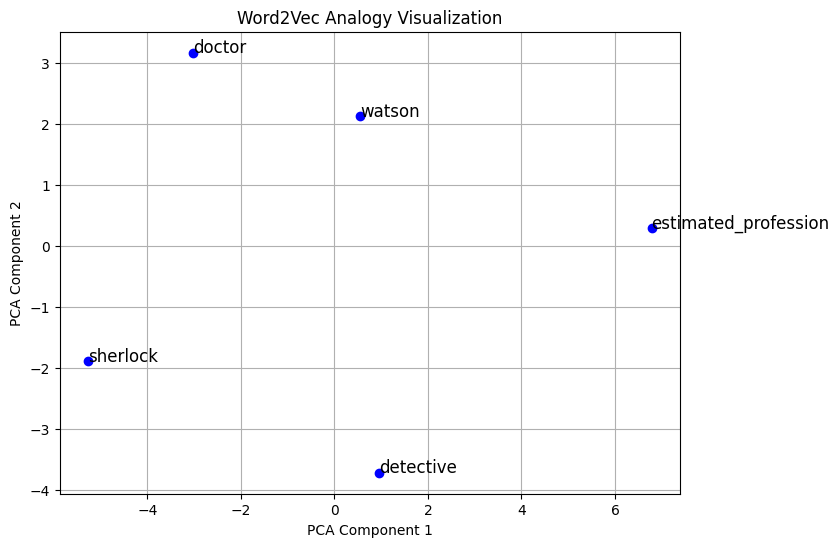

In [102]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Reduce to 2D using PCA
pca = PCA(n_components=2)
# Collect vectors for visualization
words = ["sherlock", "detective", "watson", "doctor" , "estimated_profession"]
vectors = np.array([example_name, example_profession, question_name,  w2v_model.wv.get_vector("doctor"), question_capital_estimated])

vectors_2d = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], color='blue')

# Annotate each point
for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=12)

plt.title("Word2Vec Analogy Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

### Conclusiones